# Load Kinecal Data ELEC872 Project
### Cameron Bishop | November 16th 2022

In [62]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp
from hyperopt.pyll.stochastic import scope

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)



<module 'models' from 'c:\\Users\\camb7\\Code Repositories\\KINECAL Balance Assessment\\KINECAL-Balance-Assessment\\models.py'>

In [63]:
user = User.CD
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0], user) 
QSOpenDf = readKinecalFiles(excerciseList[1], user) 
SemiTandemDf = readKinecalFiles(excerciseList[2], user) 
TandemDf = readKinecalFiles(excerciseList[3], user) 


### Seperate X and Y Dataframes

In [64]:
yDf = QSClosedDf.iloc[:, 0:9]
yDf = yDf.drop(columns='movement')

QSClosedXDf = QSClosedDf.iloc[:, 9:-1]
QSOpenXDf = QSOpenDf.iloc[:, 9:-1]
SemiTandemXDf = SemiTandemDf.iloc[:, 9:-1]
TandemXDf = TandemDf.iloc[:, 9:-1]

print(yDf)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
0       10    HA   m    1.85    77.0  22.5                   1   
1      100    NF   f    1.55    82.5  34.3                   1   
2       11    HA   f    1.57    51.5  20.9                   1   
3       12    HA   m    1.64    68.5  25.5                   1   
4       13    HA   m    1.78    85.0  26.8                   1   
..     ...   ...  ..     ...     ...   ...                 ...   
85      84   FHm   f    1.56    60.0  24.7                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   
87       9    HA   m    1.69    75.0  26.3                   1   
88      92    NF   m    1.83    97.0  29.0                   0   
89      96   FHs   m    1.78    81.2  25.6                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86             

### Replace Missing Data With Mean of That Class

In [65]:
QSClosedXDf = replaceMissingValues(QSClosedXDf, yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf, yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf, yDf)
TandemXDf = replaceMissingValues(TandemXDf, yDf)


[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normalization

In [66]:
#print(np.asarray(QS_Closed_x_df.iloc[0,:].values))
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [67]:
print(QSClosedXNormDf.shape, QSOpenXNormDf.shape, SemiTandemXNormDf.shape, TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf, QSOpenXNormDf, SemiTandemXNormDf, TandemXDf], axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Seperate Into Training and Testing Sets

In [68]:

xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

le = LabelEncoder()

yTest_orig = yTest
yTrain_orig = yTrain

xTest_orig = xTest
xTrain_orig = xTrain

yTest = le.fit_transform(yTest.group.values)
yTrain = le.fit_transform(yTrain.group.values)

X = np.asarray(combinedXNormDf)
y = np.asarray(le.fit_transform(yDf.group.values))

xTest = np.asarray(xTest)
xTrain = np.asarray(xTrain) 



### Train XGBoost Model

In [69]:
param_space = {
    'tree_method': hp.choice('tree_method', ['exact', 'gpu_hist']),
    'objective': hp.choice('objective', ['multi:softmax']),
    'max_depth': scope.int(hp.quniform("max_depth", 3, 10, 2)),
    'gamma': hp.uniform('gamma', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'num_class': 4
}

best_clf, best_param = hyperopt_multiclass(param_space, xTrain, yTrain, xTest, yTest, num_rounds=75)

100%|██████████| 75/75 [01:12<00:00,  1.03trial/s, best loss: -0.5101892551892553] 
==============RESULTS==============
Best parameters:  {'gamma': 0.3089629843409297, 'max_depth': 6, 'min_child_weight': 3.0, 'objective': 'multi:softmax', 'subsample': 0.6698253905265533, 'tree_method': 'exact'}
Best loss:  0.5101892551892553
Time taken:  72.79891991615295
Test accuracy:  0.2361111111111111
Parameter combinations evaluated:  75


### Create Optimal XGBoost Model

In [70]:
y_pred = best_clf.predict(xTest)

y_pred_label = le.inverse_transform(y_pred)
y_test_label = le.inverse_transform(yTest)

### Create Confusion Matrix and Classification Report

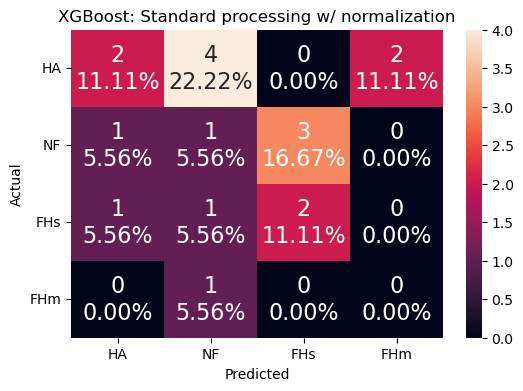

              precision    recall  f1-score   support

         FHm       0.00      0.00      0.00         1
         FHs       0.40      0.50      0.44         4
          HA       0.50      0.25      0.33         8
          NF       0.14      0.20      0.17         5

    accuracy                           0.28        18
   macro avg       0.26      0.24      0.24        18
weighted avg       0.35      0.28      0.29        18



In [71]:
classes = ['HA','NF','FHs','FHm']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('XGBoost: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))

### Remap Labels to Be Binary Single Fallers Included as Fallers

In [72]:
yTrainBinary = binaryLabelRemapping(yTrain_orig, True)
yTestBinary = binaryLabelRemapping(yTest_orig, True)

le2 = LabelEncoder()

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, True)

y_bin = np.asarray(le2.fit_transform(yDf_bin.label_binary.values))

#convert to numpy array
yTrainBinary = np.asarray(le2.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le2.fit_transform(yTestBinary.label_binary.values))

### Tune XGBoost

In [73]:
param_space = {
    'tree_method': hp.choice('tree_method', ['exact', 'gpu_hist']),
    'objective': hp.choice('objective', ['binary:logistic']),
    'max_depth': scope.int(hp.quniform("max_depth", 3, 20, 2)),
    'gamma': hp.uniform('gamma', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 1)
}

best_clf, best_param = hyperopt_binary(param_space, xTrain, yTrainBinary, xTest, yTestBinary, num_rounds=125)

100%|██████████| 125/125 [00:36<00:00,  3.41trial/s, best loss: -0.6909848484848485]
==============RESULTS==============
Best parameters:  {'gamma': 0.6158999779366946, 'max_depth': 6, 'min_child_weight': 2.0, 'objective': 'binary:logistic', 'scale_pos_weight': 0.22612660798254508, 'subsample': 0.741518471582493, 'tree_method': 'exact'}
Best loss:  0.6909848484848485
Time taken:  36.677122831344604
Test accuracy:  0.5461538461538462
Parameter combinations evaluated:  125


### Train XGBoost with Optimal Parameters For Binary Labels Single Fallers are Fallers

In [74]:
y_pred_bin = best_clf.predict(xTest)

print(roc_auc_score(y_true=yTestBinary, y_score=y_pred_bin))

#map predictions back to original labels
y_pred_label = le2.inverse_transform(y_pred_bin)
y_test_label = le2.inverse_transform(yTestBinary)

0.5461538461538462


### Create Confusion Matrix For Binary Labels

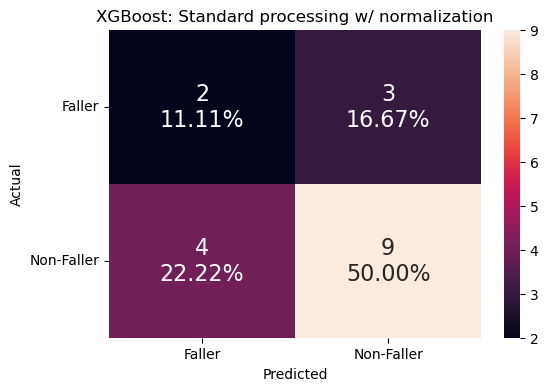

              precision    recall  f1-score   support

      Faller       0.33      0.40      0.36         5
  Non-Faller       0.75      0.69      0.72        13

    accuracy                           0.61        18
   macro avg       0.54      0.55      0.54        18
weighted avg       0.63      0.61      0.62        18



In [75]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('XGBoost: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))


### Obtain Missclassifications

In [76]:
missclassifications = yTest_bin_orig.loc[yTest_bin_orig.label_binary!=y_pred_label]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
70      68    NF   f    1.68    69.0  24.4                   0   
39      40   FHs   m    1.90   102.5  28.4                   0   
65      61    NF   m    1.73    65.3  21.8                   0   
44     404   FHm   f    1.57    63.0  25.6                   0   
35     313    NF   f    1.73    75.0  25.1                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   
4       13    HA   m    1.78    85.0  26.8                   1   

   clinically_at_risk label_binary  
70                  0   Non-Faller  
39                  0       Faller  
65                  0   Non-Faller  
44                  0       Faller  
35                  0   Non-Faller  
86                  1       Faller  
4                   0   Non-Faller  


### Remap Labels to Be Binary Single Fallers Included as Non-Fallers

In [77]:
yTrainBinary = binaryLabelRemapping(yTrain_orig, False)
yTestBinary = binaryLabelRemapping(yTest_orig, False)

le3 = LabelEncoder()

yTrain_bin_orig = yTrainBinary
yTest_bin_orig = yTestBinary

yDf_bin = binaryLabelRemapping(yDf, False)

y_bin = np.asarray(le3.fit_transform(yDf_bin.label_binary.values))

#convert to numpy array
yTrainBinary = np.asarray(le3.fit_transform(yTrainBinary.label_binary.values))
yTestBinary = np.asarray(le3.fit_transform(yTestBinary.label_binary.values))

### Tune XGBoost

In [78]:
param_space = {
    'tree_method': hp.choice('tree_method', ['exact', 'gpu_hist']),
    'objective': hp.choice('objective', ['binary:logistic']),
    'max_depth': scope.int(hp.quniform("max_depth", 3, 20, 2)),
    'gamma': hp.uniform('gamma', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 1)
}

best_clf, best_param = hyperopt_binary(param_space, xTrain, yTrainBinary, xTest, yTestBinary, num_rounds=125)

100%|██████████| 125/125 [00:36<00:00,  3.41trial/s, best loss: -0.8115384615384615]
==============RESULTS==============
Best parameters:  {'gamma': 0.8845229291837415, 'max_depth': 18, 'min_child_weight': 2.0, 'objective': 'binary:logistic', 'scale_pos_weight': 0.9279879095912247, 'subsample': 0.8099956782067764, 'tree_method': 'exact'}
Best loss:  0.8115384615384615
Time taken:  36.70180010795593
Test accuracy:  0.47058823529411764
Parameter combinations evaluated:  125


### Train XGBoost with Optimal Parameters Single Fallers Considered Non-Fallers

In [79]:
y_pred_bin = best_clf.predict(xTest)

#map predictions back to original labels
y_pred_label = le2.inverse_transform(y_pred_bin)
y_test_label = le2.inverse_transform(yTestBinary)

### Create Confusion Matrix For Binary Labels FHs -> Non-Fallers

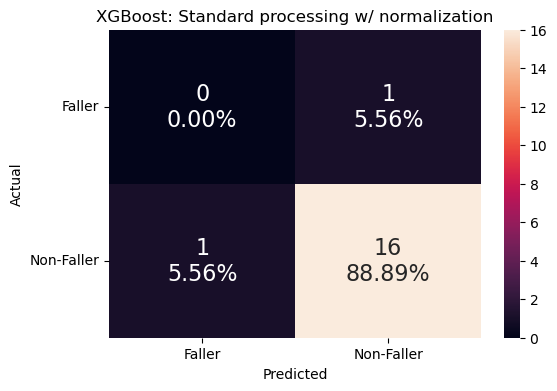

              precision    recall  f1-score   support

      Faller       0.00      0.00      0.00         1
  Non-Faller       0.94      0.94      0.94        17

    accuracy                           0.89        18
   macro avg       0.47      0.47      0.47        18
weighted avg       0.89      0.89      0.89        18



In [80]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('XGBoost: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))

### Obtain Missclassifications

In [81]:
missclassifications = yTest_bin_orig.loc[yTest_bin_orig.label_binary!=y_pred_label]
print(missclassifications)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
10      19    HA   m    1.78    79.0  24.9                   1   
44     404   FHm   f    1.57    63.0  25.6                   0   

   clinically_at_risk label_binary  
10                  0   Non-Faller  
44                  0       Faller  
